In [ ]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [ ]:
!pip -q uninstall -y flwr
!pip -q install --no-deps "flwr==1.7.*" "iterators==0.0.2"

import sys, numpy as np, pandas as pd, tensorflow as tf, flwr
print("Python", sys.version)
print("TensorFlow", tf.__version__)
print("Flower", flwr.__version__)


Python 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow 2.18.0
Flower 1.7.0


In [ ]:
import numpy as np, pandas as pd
from typing import List
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import flwr as fl
from flwr.common import parameters_to_ndarrays

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "/kaggle/input/nslkdd"
TRAIN_PATH = f"{DATA_DIR}/KDDTrain+.txt"
TEST_PATH  = f"{DATA_DIR}/KDDTest+.txt"

In [ ]:
feature_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
    "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
    "num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"
]
columns = feature_names + ["attack", "difficulty"]

train_raw = pd.read_csv(TRAIN_PATH, names=columns)
test_raw  = pd.read_csv(TEST_PATH,  names=columns)
print(train_raw.shape, test_raw.shape)
train_raw.head(3)


(125973, 43) (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [ ]:
train_for_split = train_raw[["attack"]].copy()

train_raw["label"] = (train_raw["attack"] != "normal").astype(int)
test_raw["label"]  = (test_raw["attack"]  != "normal").astype(int)

cat_cols = ["protocol_type","service","flag"]
train_drop = train_raw.drop(columns=["difficulty"])
test_drop  = test_raw.drop(columns=["difficulty"])

cat_all = pd.get_dummies(pd.concat([train_drop[cat_cols], test_drop[cat_cols]], axis=0),
                         columns=cat_cols)
train_cat = cat_all.iloc[:len(train_drop)].reset_index(drop=True)
test_cat  = cat_all.iloc[len(train_drop):].reset_index(drop=True)

train_num = train_drop.drop(columns=cat_cols).reset_index(drop=True)
test_num  = test_drop.drop(columns=cat_cols).reset_index(drop=True)

train_proc = pd.concat([train_num, train_cat], axis=1)
test_proc  = pd.concat([test_num,  test_cat], axis=1)

feature_cols = [c for c in train_proc.columns if c not in ("attack","label")]
X_train = train_proc[feature_cols].values
y_train = train_proc["label"].values
X_test  = test_proc[feature_cols].values
y_test  = test_proc["label"].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

input_dim = X_train.shape[1]
input_dim


122

In [ ]:
dos   = ["back","land","neptune","pod","smurf","teardrop"]
probe = ["ipsweep","nmap","portsweep","satan"]
r2l   = ["ftp_write","guess_passwd","imap","multihop","phf","spy","warezclient","warezmaster"]
u2r   = ["buffer_overflow","loadmodule","perl","rootkit"]

mask_dos    = train_for_split["attack"].isin(dos).values
mask_probe  = train_for_split["attack"].isin(probe).values
mask_r2l    = train_for_split["attack"].isin(r2l).values
mask_u2r    = train_for_split["attack"].isin(u2r).values
mask_normal = train_for_split["attack"].eq("normal").values

idx_dos, idx_probe = np.where(mask_dos)[0], np.where(mask_probe)[0]
idx_r2l, idx_u2r   = np.where(mask_r2l)[0], np.where(mask_u2r)[0]
idx_normal         = np.where(mask_normal)[0]

rng = np.random.RandomState(SEED)
used_normals = set()

def make_node_subset(idx_attack, used_set):
    need = len(idx_attack)
    avail = np.array([i for i in idx_normal if i not in used_set])
    chosen = rng.choice(avail, size=need, replace=False)
    used_set.update(chosen.tolist())
    idx_total = np.concatenate([idx_attack, chosen])
    rng.shuffle(idx_total)
    return X_train[idx_total], y_train[idx_total]

X1, y1 = make_node_subset(idx_dos,   used_normals)
X2, y2 = make_node_subset(idx_probe, used_normals)
X3, y3 = make_node_subset(idx_r2l,   used_normals)
X4, y4 = make_node_subset(idx_u2r,   used_normals)

for i,(X,y) in enumerate([(X1,y1),(X2,y2),(X3,y3),(X4,y4)], 1):
    print(f"Node{i}: {len(y)}  (attacks={y.sum()}, normal={(y==0).sum()})")


Node1: 91854  (attacks=45927, normal=45927)
Node2: 23312  (attacks=11656, normal=11656)
Node3: 1990  (attacks=995, normal=995)
Node4: 104  (attacks=52, normal=52)


In [ ]:
def create_model(hidden_units: List[int] = [288]) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,))
    
    x = inputs
    
    for u in hidden_units:
        x = layers.Dense(u, activation="relu")(x)
        
    outputs = layers.Dense(2, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

def to_cat(y: np.ndarray) -> np.ndarray:
    return keras.utils.to_categorical(y, num_classes=2)


In [ ]:
central_model = create_model()
central_model.fit(X_train, to_cat(y_train), epochs=5, batch_size=256, verbose=0)
central_loss, central_acc = central_model.evaluate(X_test, to_cat(y_test), verbose=0)
print(f"[Centralized] ACC: {central_acc:.4f}")


[Centralized] ACC: 0.7832


In [ ]:
acc_local = {}
for i,(X,y) in enumerate([(X1,y1),(X2,y2),(X3,y3),(X4,y4)], 1):
    m = create_model()
    m.fit(X, to_cat(y), epochs=5, batch_size=256, verbose=0)
    _, acc = m.evaluate(X_test, to_cat(y_test), verbose=0)
    acc_local[f"Node{i}"] = acc

acc_local


{'Node1': 0.7578956484794617,
 'Node2': 0.698145866394043,
 'Node3': 0.4834545850753784,
 'Node4': 0.4801720976829529}

In [ ]:
class IDSClient(fl.client.NumPyClient):
    def __init__(self, cid: int, X: np.ndarray, y: np.ndarray, hidden: List[int] = [288]):
        self.cid = cid
        self.X_full = X
        self.y_full = y
        self.order = np.arange(len(self.X_full))
        np.random.RandomState(SEED).shuffle(self.order)
        self.model = create_model(hidden_units=hidden)

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        server_round = int(config.get("server_round", 1))
        frac = min(max(server_round,1),5) / 5.0
        n = max(1, int(len(self.order)*frac))
        idx = self.order[:n]
        X_local = self.X_full[idx]
        y_local = self.y_full[idx]
        self.model.fit(X_local, to_cat(y_local), epochs=1, batch_size=256, verbose=0)
        return self.model.get_weights(), len(X_local), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(X_test, to_cat(y_test), verbose=0)
        return float(loss), len(y_test), {"accuracy": float(acc)}

def client_fn(cid: str):
    i = int(cid)
    if i == 0: return IDSClient(0, X1, y1)
    if i == 1: return IDSClient(1, X2, y2)
    if i == 2: return IDSClient(2, X3, y3)
    if i == 3: return IDSClient(3, X4, y4)
    raise ValueError("bad cid")

global_eval_model = create_model(hidden_units=[288])

client_resources = {"num_cpus": 1, "num_gpus": 0.15}

In [ ]:
from flwr.common import parameters_to_ndarrays

global_eval_model = create_model()

def server_eval_fn(params_or_weights):
    try:
        weights = parameters_to_ndarrays(params_or_weights)
    except Exception:
        weights = params_or_weights
    global_eval_model.set_weights(weights)
    loss, acc = global_eval_model.evaluate(X_test, to_cat(y_test), verbose=0)
    return float(loss), {"accuracy": float(acc)}

class SaveFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_params = None
        self.round_metrics = []

    def aggregate_fit(self, server_round, results, failures):
        aggregated, metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated is not None:
            self.final_params = aggregated
        return aggregated, metrics

    def evaluate(self, server_round, parameters):
        loss, metrics = server_eval_fn(parameters)
        self.round_metrics.append((server_round, metrics["accuracy"]))
        return loss, metrics

strategy = SaveFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.0,
    min_fit_clients=4,
    min_evaluate_clients=0,
    min_available_clients=4,
)


In [ ]:
client_resources = {"num_cpus": 1, "num_gpus": 0.15}

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={
        "num_cpus": 4,
        "num_gpus": 1,
        "include_dashboard": False,
    },
)

INFO flwr 2025-11-23 14:25:35,354 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-11-23 14:25:40,415	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO flwr 2025-11-23 14:25:44,882 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:P100': 1.0, 'GPU': 1.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'object_store_memory': 8632087756.0, 'memory': 20141538100.0}
INFO flwr 2025-11-23 14:25:44,882 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-11-23 14:25:44,883 | 

In [ ]:
final_nd = parameters_to_ndarrays(strategy.final_params)
global_eval_model.set_weights(final_nd)

fl_loss, fl_acc = global_eval_model.evaluate(X_test, to_cat(y_test), verbose=0)
print(f"[FL Round5] ACC: {fl_acc:.4f}")
print(f"[Centralized] ACC: {central_acc:.4f}")
print("[Self] ACCs:", acc_local)

def report(model, name):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print(f"\n[{name}]")
    print("ACC:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Normal","Attack"]))

report(central_model, "Centralized")
report(global_eval_model, "Federated (Round5)")


[FL Round5] ACC: 0.7421
[Centralized] ACC: 0.7832
[Self] ACCs: {'Node1': 0.7578956484794617, 'Node2': 0.698145866394043, 'Node3': 0.4834545850753784, 'Node4': 0.4801720976829529}

[Centralized]
ACC: 0.7832239176721079
Confusion Matrix:
 [[9423  288]
 [4599 8234]]
              precision    recall  f1-score   support

      Normal       0.67      0.97      0.79      9711
      Attack       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544


[Federated (Round5)]
ACC: 0.7421486870120653
Confusion Matrix:
 [[9208  503]
 [5310 7523]]
              precision    recall  f1-score   support

      Normal       0.63      0.95      0.76      9711
      Attack       0.94      0.59      0.72     12833

    accuracy                           0.74     22544
   macro avg       0.79      0.77      0.74     22544
weighted avg       0.81      0.74      0.74  

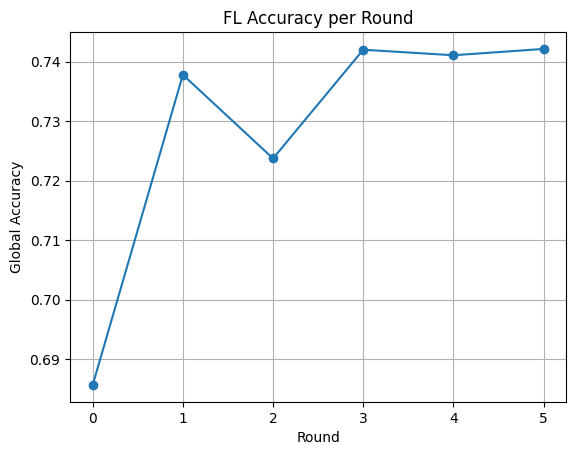

In [ ]:
import matplotlib.pyplot as plt
r = [r for r,_ in strategy.round_metrics]
a = [acc for _,acc in strategy.round_metrics]
plt.figure()
plt.plot(r, a, marker="o")
plt.xlabel("Round"); plt.ylabel("Global Accuracy")
plt.title("FL Accuracy per Round"); plt.grid(True)
plt.show()


Saved: 1_learning_curve.png


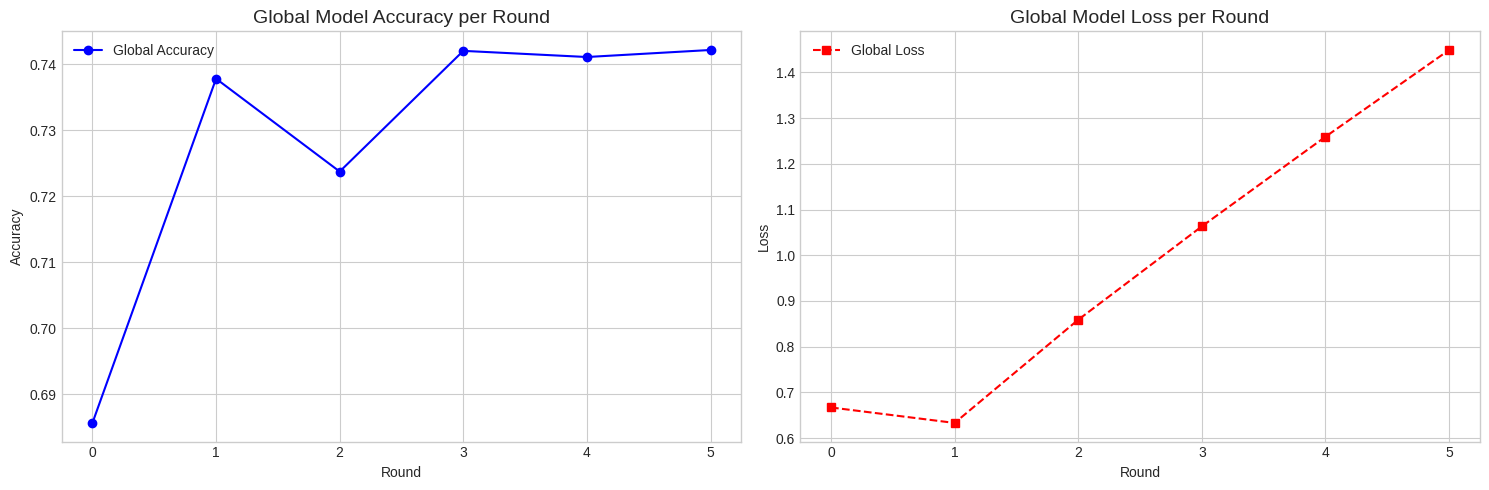

Saved: 2_data_distribution.png


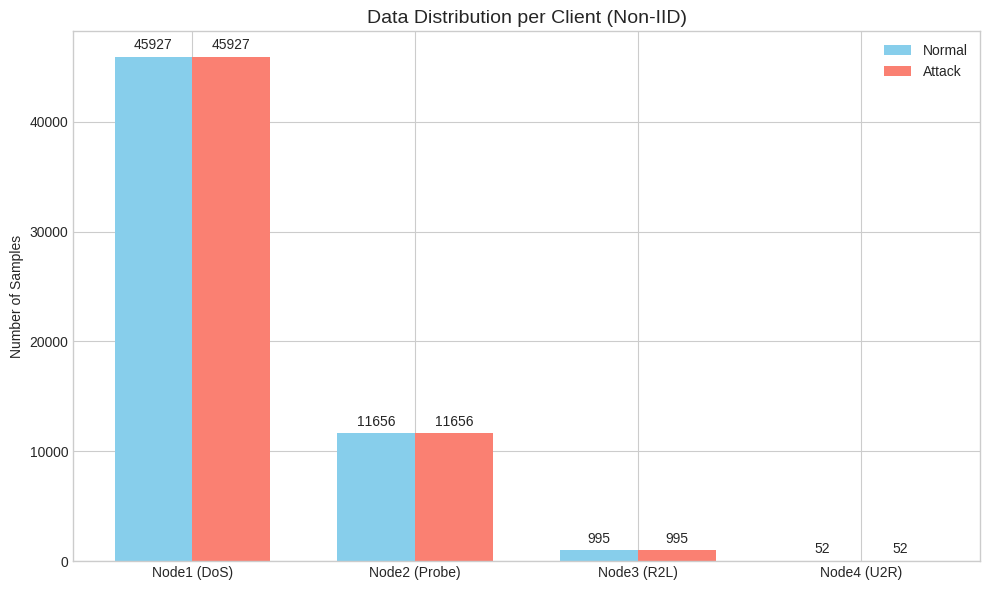

Saved: 3_performance_comparison.png


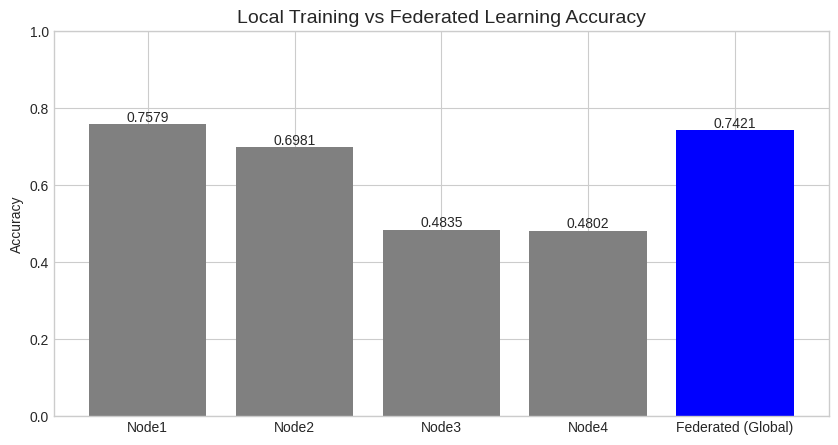

Saved: 4_confusion_matrix.png


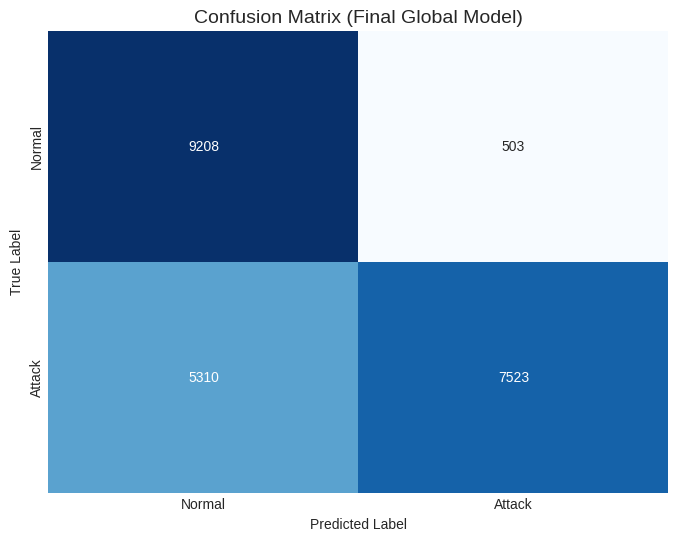

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

rounds = [r for r, _ in strategy.round_metrics]
acc = [acc for _, acc in strategy.round_metrics]
loss_history = history.losses_centralized
loss_rounds = [r for r, l in loss_history]
loss_values = [l for r, l in loss_history]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(rounds, acc, marker='o', linestyle='-', color='b', label='Global Accuracy')
ax[0].set_title('Global Model Accuracy per Round', fontsize=14)
ax[0].set_xlabel('Round')
ax[0].set_ylabel('Accuracy')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(loss_rounds, loss_values, marker='s', linestyle='--', color='r', label='Global Loss')
ax[1].set_title('Global Model Loss per Round', fontsize=14)
ax[1].set_xlabel('Round')
ax[1].set_ylabel('Loss')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()

plt.savefig('1_learning_curve.png', dpi=300, bbox_inches='tight')
print("Saved: 1_learning_curve.png")

plt.show()

client_labels = [y1, y2, y3, y4]
client_names = ['Node1 (DoS)', 'Node2 (Probe)', 'Node3 (R2L)', 'Node4 (U2R)']

normal_counts = []
attack_counts = []

for y in client_labels:
    unique, counts = np.unique(y, return_counts=True)
    count_dict = dict(zip(unique, counts))
    normal_counts.append(count_dict.get(0, 0)) # 0: Normal
    attack_counts.append(count_dict.get(1, 0)) # 1: Attack

x = np.arange(len(client_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal', color='skyblue')
rects2 = ax.bar(x + width/2, attack_counts, width, label='Attack', color='salmon')

ax.set_ylabel('Number of Samples')
ax.set_title('Data Distribution per Client (Non-IID)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(client_names)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()

plt.savefig('2_data_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: 2_data_distribution.png")

plt.show()

local_acc_values = list(acc_local.values())
labels = list(acc_local.keys()) + ['Federated (Global)']
values = local_acc_values + [fl_acc]
colors = ['gray'] * len(acc_local) + ['blue']

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=colors)
plt.title("Local Training vs Federated Learning Accuracy", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.savefig('3_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: 3_performance_comparison.png")

plt.show()


y_pred_global = np.argmax(global_eval_model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred_global)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix (Final Global Model)', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('4_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: 4_confusion_matrix.png")

plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


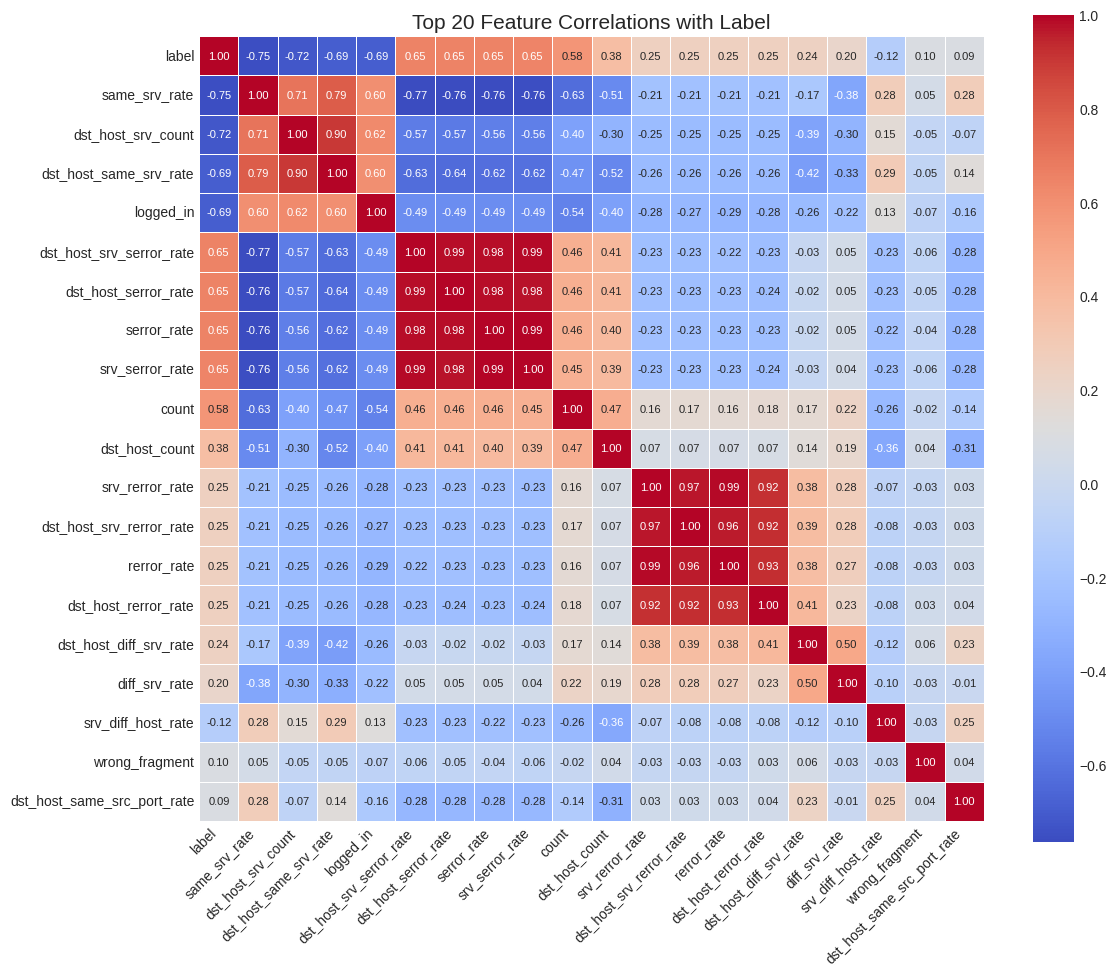

In [ ]:
import seaborn as sns

def plot_correlation_heatmap(df, num_features=20):
    plt.figure(figsize=(12, 10))
    
    numeric_df = df.select_dtypes(include=[np.number])
    if 'label' in numeric_df.columns:
        target_corr = numeric_df.corrwith(numeric_df['label']).abs().sort_values(ascending=False)
    else:
        
        target_corr = numeric_df.var().sort_values(ascending=False)
    
    top_features = target_corr.head(num_features).index
    corr_mat = numeric_df[top_features].corr()

    sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='coolwarm', 
                cbar=True, square=True, linewidths=.5, annot_kws={"size": 8})
    plt.title(f'Top {num_features} Feature Correlations with Label', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('Top 20 Feature', dpi=300, bbox_inches='tight')
    plt.show()

plot_correlation_heatmap(train_proc)

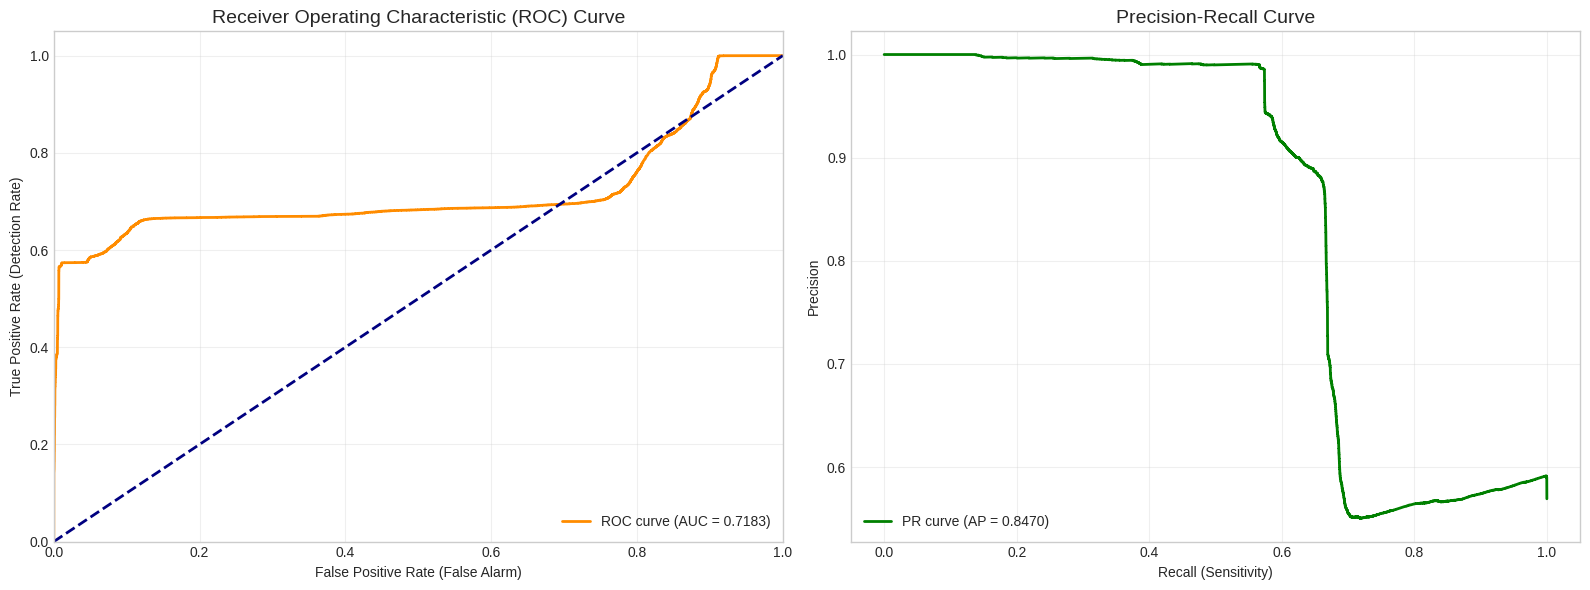

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

y_pred_prob = global_eval_model.predict(X_test, verbose=0)
y_pred_score = y_pred_prob[:, 1]  # Attack 클래스(1)일 확률

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)

ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate (False Alarm)')
ax[0].set_ylabel('True Positive Rate (Detection Rate)')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
ax[0].legend(loc="lower right")
ax[0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_score)
pr_auc = average_precision_score(y_test, y_pred_score)

ax[1].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {pr_auc:.4f})')
ax[1].set_xlabel('Recall (Sensitivity)')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve', fontsize=14)
ax[1].legend(loc="lower left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Receiver Operating Characteristic (ROC) Curve', dpi=300, bbox_inches='tight')
plt.show()

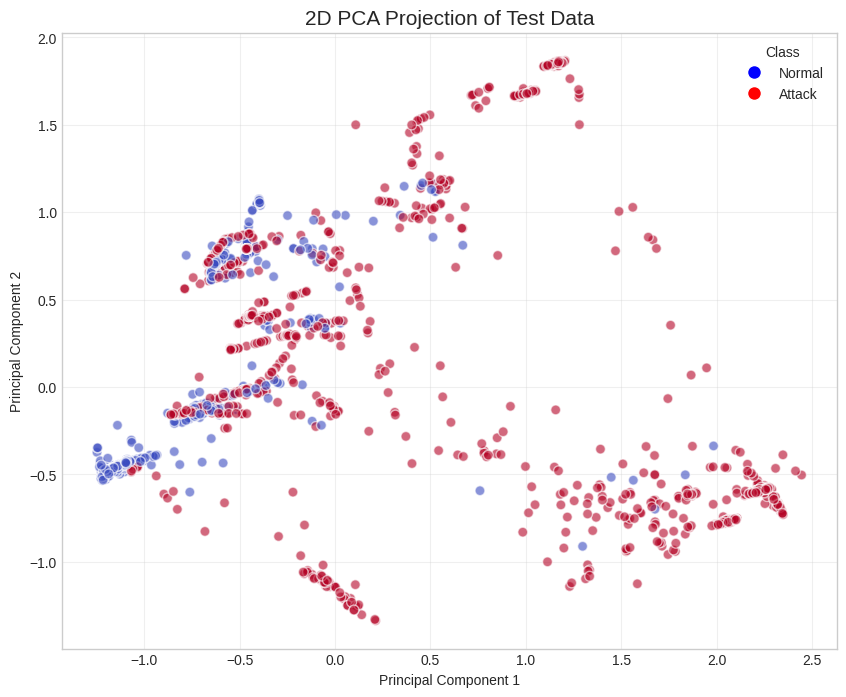

In [ ]:
from sklearn.decomposition import PCA

sample_size = 2000
idx = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[idx]
y_sample = y_test[idx]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6, edgecolors='w', s=50)
plt.title('2D PCA Projection of Test Data', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

classes = ['Normal', 'Attack']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in ['blue', 'red']]
plt.legend(handles, classes, title="Class")
plt.grid(True, alpha=0.3)
plt.show()

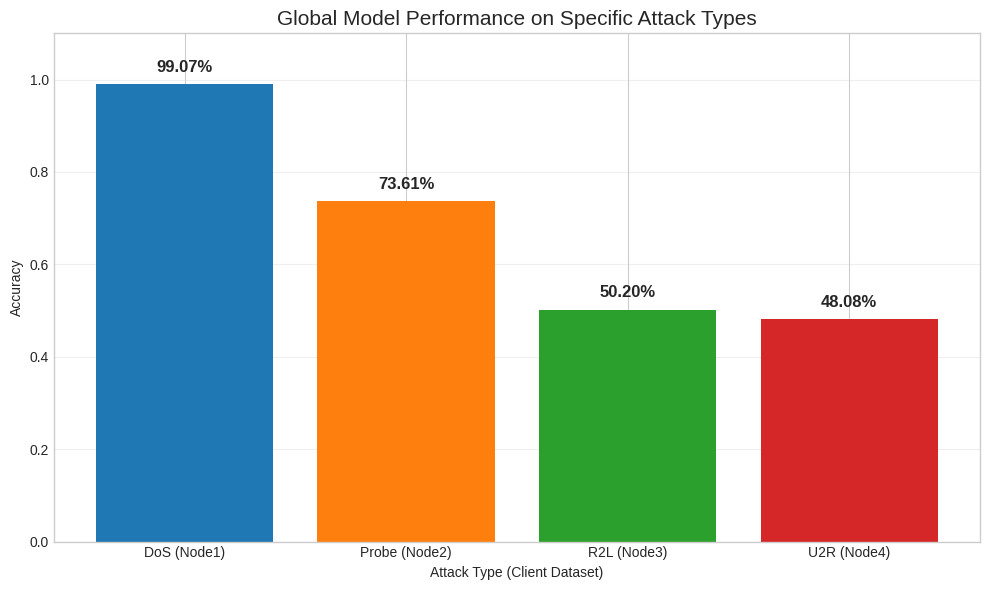

In [ ]:

client_datasets = [(X1, y1, "DoS (Node1)"), 
                   (X2, y2, "Probe (Node2)"), 
                   (X3, y3, "R2L (Node3)"), 
                   (X4, y4, "U2R (Node4)")]

accuracies = []
attack_types = []

for X_c, y_c, name in client_datasets:
    loss, acc = global_eval_model.evaluate(X_c, to_cat(y_c), verbose=0)
    accuracies.append(acc)
    attack_types.append(name)

plt.figure(figsize=(10, 6))
bars = plt.bar(attack_types, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('Global Model Performance on Specific Attack Types', fontsize=15)
plt.xlabel('Attack Type (Client Dataset)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Global Model Performance on Specific Attack Types.png', dpi=300, bbox_inches='tight')
plt.show()

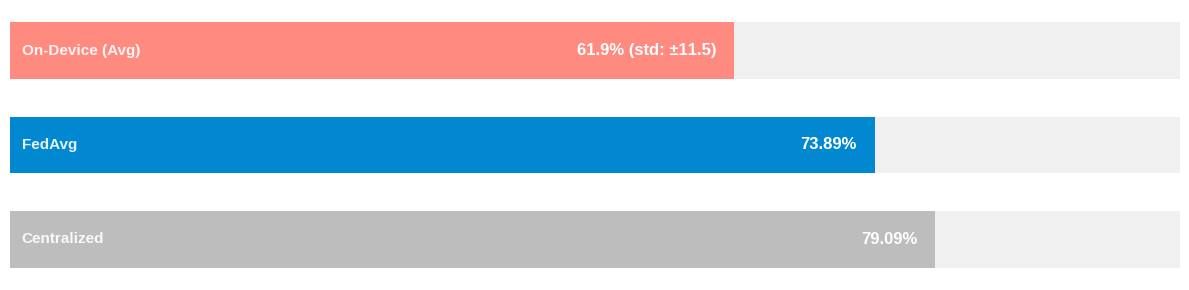

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

acc_local_values = [0.7655, 0.6957, 0.4927, 0.5224]
fl_acc = 0.7389
central_acc = 0.7909

avg_on_device = np.mean(acc_local_values) * 100
fed_avg_val = fl_acc * 100
central_val = central_acc * 100
std_dev = np.std(acc_local_values) * 100  

# 데이터 구성
categories = ['On-Device (Avg)', 'FedAvg', 'Centralized']
values = [avg_on_device, fed_avg_val, central_val]
colors = ['#FF8A80', '#0288D1', '#BDBDBD']  

fig, ax = plt.subplots(figsize=(12, 3))

ax.barh(categories, [100]*3, color='#F0F0F0', height=0.6, align='center')

bars = ax.barh(categories, values, color=colors, height=0.6, align='center')

for bar, value, category in zip(bars, values, categories):
    width = bar.get_width()
    
    if category == 'On-Device (Avg)':
        label_text = f"{width:.1f}% (std: ±{std_dev:.1f})"
    else:
        label_text = f"{width:.2f}%"

    ax.text(width - 1.5, bar.get_y() + bar.get_height()/2, 
            label_text, 
            ha='right', va='center', 
            color='white', fontweight='bold', fontsize=12)
    
    ax.text(1, bar.get_y() + bar.get_height()/2, 
            category, 
            ha='left', va='center', 
            color='white', fontweight='bold', fontsize=11, alpha=0.9)

ax.set_xlim(0, 100)
ax.invert_yaxis()  
ax.axis('off')     

plt.tight_layout()
plt.savefig('compare.png', dpi=300, bbox_inches='tight')
plt.show()

Generating predictions for comparison...
Centralized Acc: 0.7832, Federated Acc: 0.7421
Saved: compare_1_accuracy.png


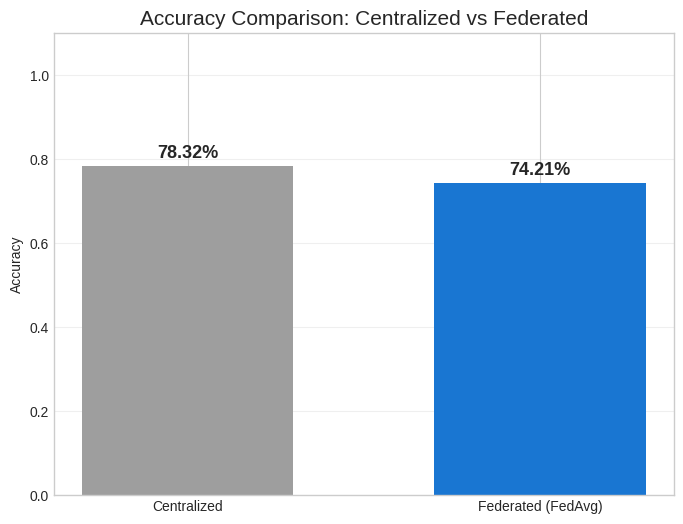

Saved: compare_2_roc.png


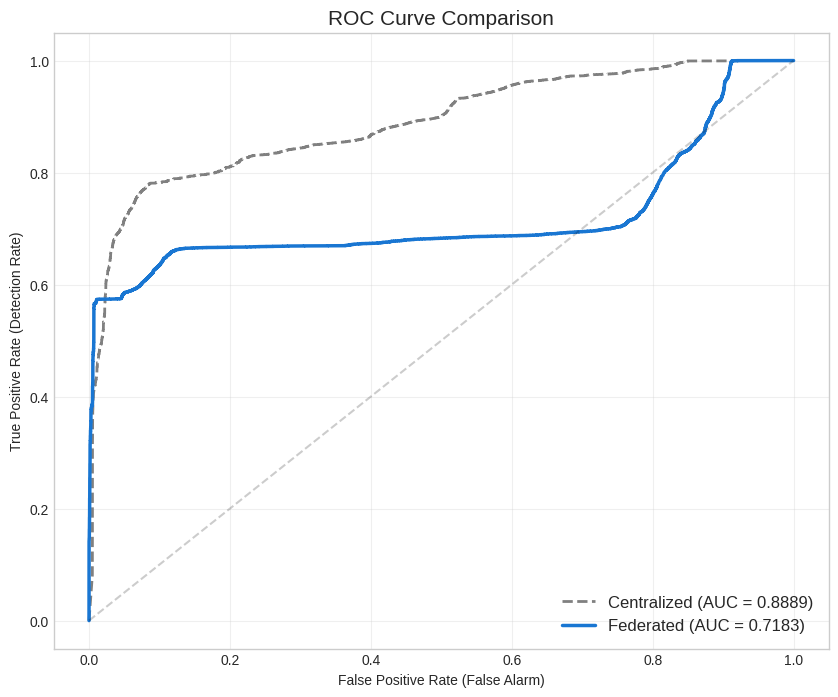

Saved: compare_3_pr_curve.png


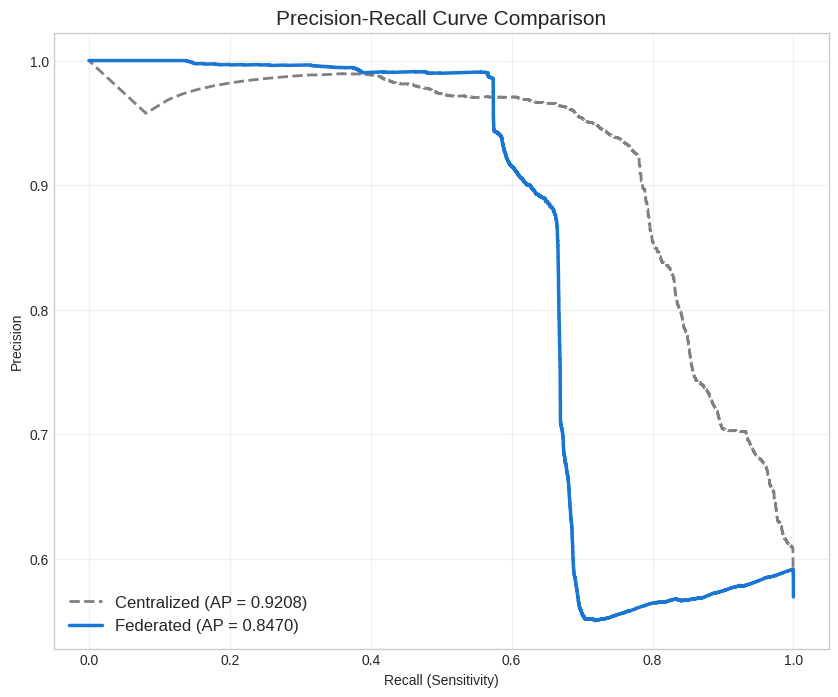

Saved: compare_4_confusion_matrix.png


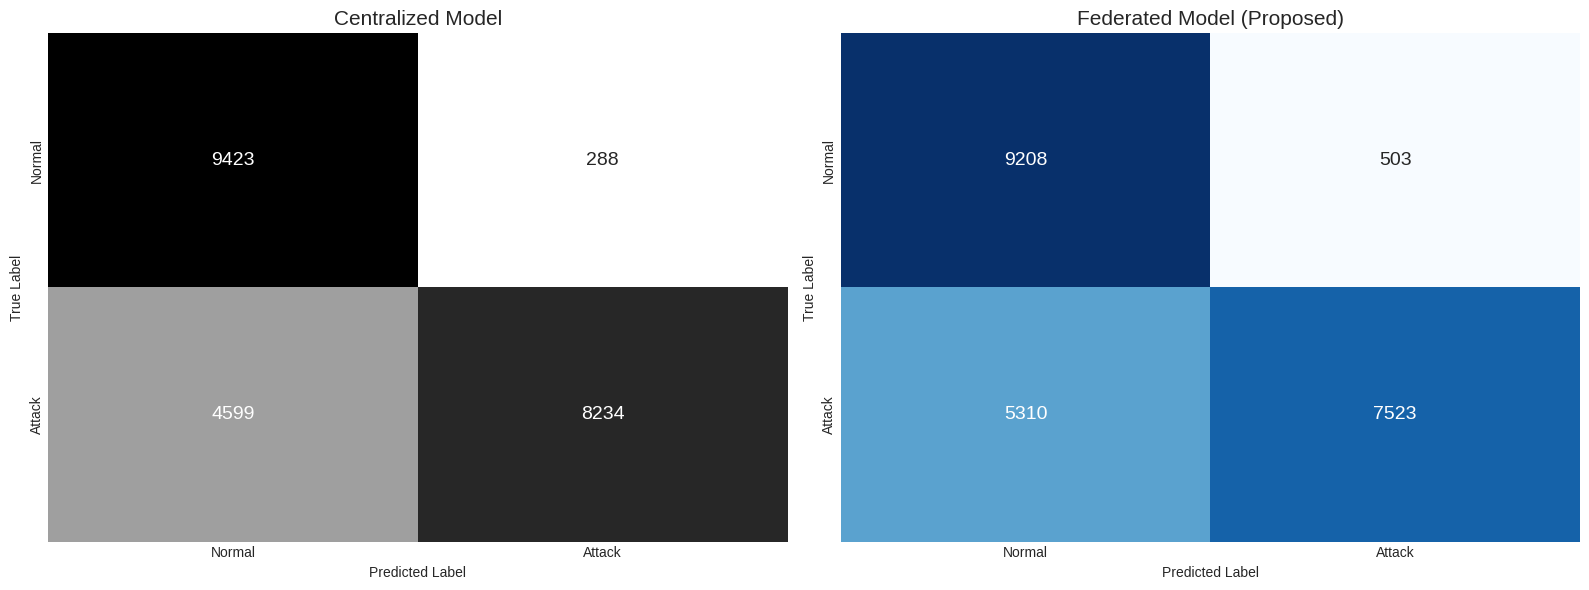

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

print("Generating predictions for comparison...")

y_prob_cen = central_model.predict(X_test, verbose=0)
y_prob_fl = global_eval_model.predict(X_test, verbose=0)

y_score_cen = y_prob_cen[:, 1] # Attack 클래스일 확률
y_score_fl = y_prob_fl[:, 1]

y_pred_cen = np.argmax(y_prob_cen, axis=1)
y_pred_fl = np.argmax(y_prob_fl, axis=1)


acc_cen = accuracy_score(y_test, y_pred_cen)
acc_fl = accuracy_score(y_test, y_pred_fl)

print(f"Centralized Acc: {acc_cen:.4f}, Federated Acc: {acc_fl:.4f}")

plt.figure(figsize=(8, 6))
bars = plt.bar(['Centralized', 'Federated (FedAvg)'], [acc_cen, acc_fl], 
               color=['#9E9E9E', '#1976D2'], width=0.6) 

plt.title('Accuracy Comparison: Centralized vs Federated', fontsize=15)
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{height:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.savefig('compare_1_accuracy.png', dpi=300, bbox_inches='tight')
print("Saved: compare_1_accuracy.png")
plt.show()

fpr_cen, tpr_cen, _ = roc_curve(y_test, y_score_cen)
auc_cen = auc(fpr_cen, tpr_cen)

fpr_fl, tpr_fl, _ = roc_curve(y_test, y_score_fl)
auc_fl = auc(fpr_fl, tpr_fl)

plt.figure(figsize=(10, 8))
plt.plot(fpr_cen, tpr_cen, label=f'Centralized (AUC = {auc_cen:.4f})', 
         linestyle='--', color='gray', linewidth=2)
plt.plot(fpr_fl, tpr_fl, label=f'Federated (AUC = {auc_fl:.4f})', 
         color='#1976D2', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2) 

plt.title('ROC Curve Comparison', fontsize=15)
plt.xlabel('False Positive Rate (False Alarm)')
plt.ylabel('True Positive Rate (Detection Rate)')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig('compare_2_roc.png', dpi=300, bbox_inches='tight')
print("Saved: compare_2_roc.png")
plt.show()

pre_cen, rec_cen, _ = precision_recall_curve(y_test, y_score_cen)
ap_cen = average_precision_score(y_test, y_score_cen)

pre_fl, rec_fl, _ = precision_recall_curve(y_test, y_score_fl)
ap_fl = average_precision_score(y_test, y_score_fl)

plt.figure(figsize=(10, 8))
plt.plot(rec_cen, pre_cen, label=f'Centralized (AP = {ap_cen:.4f})', 
         linestyle='--', color='gray', linewidth=2)
plt.plot(rec_fl, pre_fl, label=f'Federated (AP = {ap_fl:.4f})', 
         color='#1976D2', linewidth=2.5)

plt.title('Precision-Recall Curve Comparison', fontsize=15)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig('compare_3_pr_curve.png', dpi=300, bbox_inches='tight')
print("Saved: compare_3_pr_curve.png")
plt.show()

cm_cen = confusion_matrix(y_test, y_pred_cen)
cm_fl = confusion_matrix(y_test, y_pred_fl)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_cen, annot=True, fmt='d', cmap='Greys', ax=axes[0], cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], annot_kws={"size": 14})
axes[0].set_title('Centralized Model', fontsize=15)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], annot_kws={"size": 14})
axes[1].set_title('Federated Model (Proposed)', fontsize=15)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('compare_4_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: compare_4_confusion_matrix.png")
plt.show()

Saved: nodes_vs_fedavg_vs_centralized.png


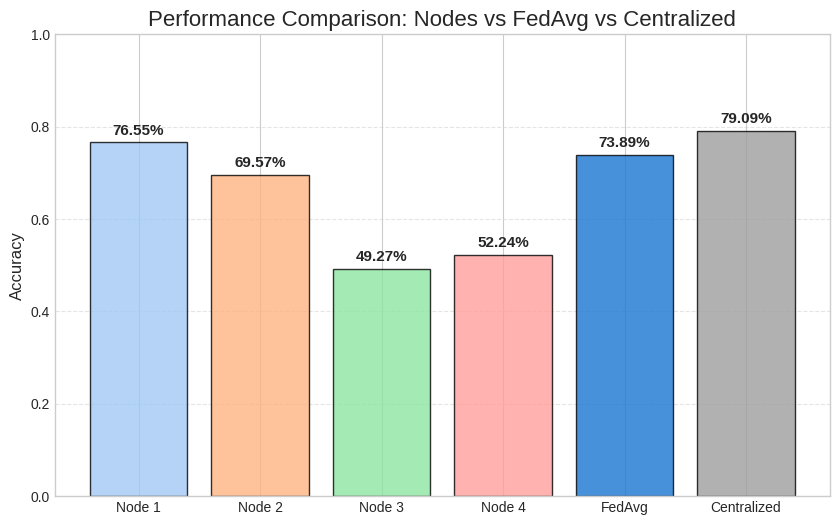

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_local_values = [0.7655, 0.6957, 0.4927, 0.5224] # Node 1, 2, 3, 4
fl_acc = 0.7389
central_acc = 0.7909

labels = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'FedAvg', 'Centralized']
values = acc_local_values + [fl_acc, central_acc]
colors = sns.color_palette("pastel", 4) + ['#1976D2', '#9E9E9E']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors, edgecolor='black', alpha=0.8)

plt.title('Performance Comparison: Nodes vs FedAvg vs Centralized', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{height:.2%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.savefig('nodes_vs_fedavg_vs_centralized.png', dpi=300, bbox_inches='tight')
print("Saved: nodes_vs_fedavg_vs_centralized.png")

plt.show()